In [1]:
import diffrax
import jax
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt
import diffrax as dfx

from pde_opt.numerics.domains import Domain
from pde_opt.numerics.shapes import Shape
from pde_opt.numerics.equations.cahn_hilliard import CahnHilliard2DSmoothedBoundary


In [11]:
binary_mask = np.zeros((200,200))
binary_mask[15:185, 15:185] = 1

shape = Shape(binary=jnp.array(binary_mask), dx = (1.0, 1.0), smooth_params=(3.0, 0.01, 100.0))

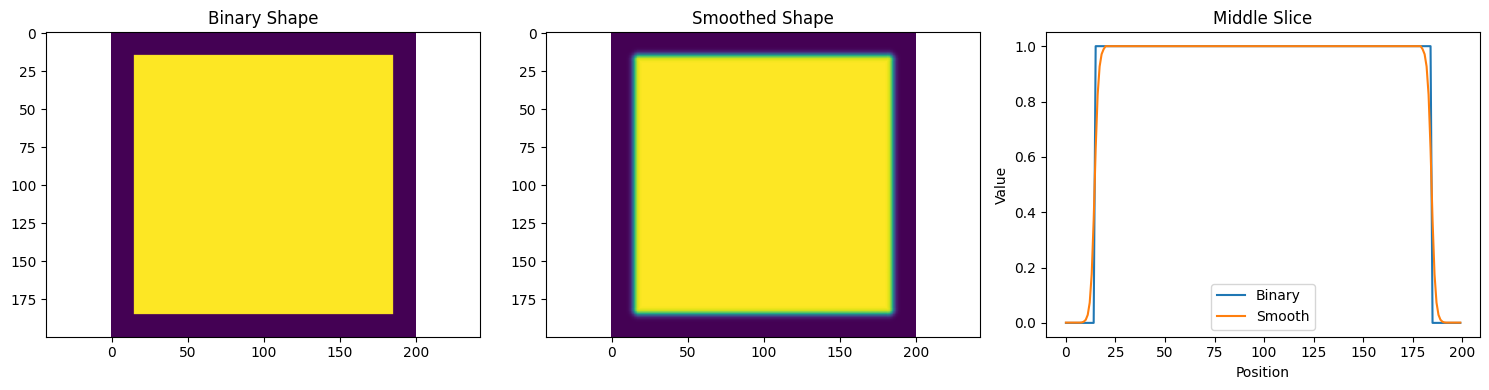

0.001
1.0


In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.imshow(shape.binary, cmap='viridis')
ax1.set_title('Binary Shape')
ax1.axis('equal')

ax2.imshow(shape.smooth, cmap='viridis') 
ax2.set_title('Smoothed Shape')
ax2.axis('equal')

# Plot slice through middle
mid_idx = shape.binary.shape[0] // 2
ax3.plot(shape.binary[mid_idx, :], label='Binary')
ax3.plot(shape.smooth[mid_idx, :], label='Smooth')
ax3.set_title('Middle Slice')
ax3.set_xlabel('Position')
ax3.set_ylabel('Value')
ax3.legend()

plt.tight_layout()
plt.show()

print(jnp.min(shape.smooth))
print(jnp.max(shape.smooth))

In [16]:
Nx, Ny = 200, 200
Lx = 0.01 * Nx
Ly = 0.01 * Ny
domain = Domain((Nx, Ny), ((-Lx / 2, Lx / 2), (-Ly / 2, Ly / 2)), "dimensionless", shape)

t_start = 0.0
t_final = 0.2
dt = 0.000001

ts_save = jnp.linspace(t_start, t_final, 200)

kappa = 0.002


In [17]:
eq = CahnHilliard2DSmoothedBoundary(
    domain,
    kappa,
    lambda c: jnp.log(c / (1.0 - c)) + 3.0 * (1.0 - 2.0 * c),
    lambda c: (1.0 - c) * c,
    derivs="fd"
)

solver = dfx.Tsit5()

In [21]:
key = random.PRNGKey(0)
u0 = 0.5 * jnp.ones((Nx, Ny)) + 0.01 * random.normal(key, (Nx, Ny))

solution = diffrax.diffeqsolve(
    diffrax.ODETerm(jax.jit(lambda t, y, args: eq.rhs(y, t))),
    solver,
    t0=t_start,
    t1=t_final,
    dt0=dt,
    y0=u0,
    stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-6),
    saveat=diffrax.SaveAt(ts=ts_save),
    max_steps=1000000,
)

print(solution.stats)

print(jnp.mean(solution.ys[0]))
print(jnp.mean(solution.ys[-1]))

{'max_steps': 1000000, 'num_accepted_steps': Array(198544, dtype=int32, weak_type=True), 'num_rejected_steps': Array(48017, dtype=int32, weak_type=True), 'num_steps': Array(246561, dtype=int32, weak_type=True)}
0.49997187
0.49600184


In [22]:
print(jnp.mean(solution.ys[0][binary_mask == 1]))
print(jnp.mean(solution.ys[-1][binary_mask == 1]))

0.5000214
0.50001025


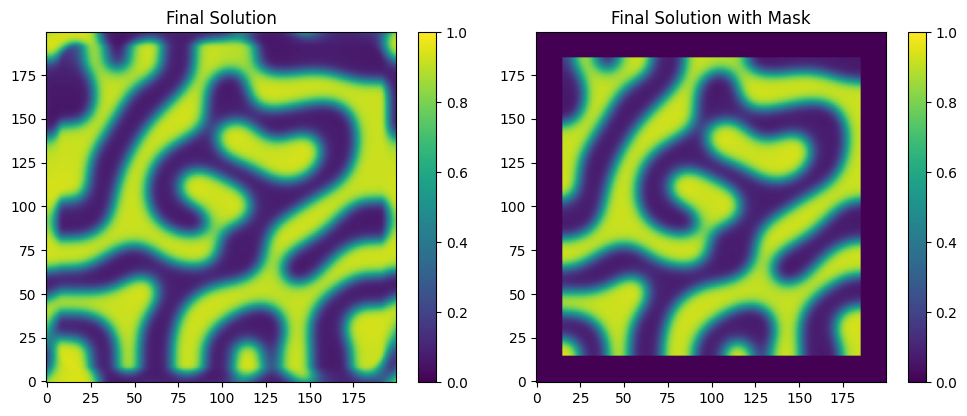

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

im1 = ax1.imshow(solution.ys[-1], origin='lower', vmin=0.0, vmax=1.0)
ax1.set_title('Final Solution')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(solution.ys[-1] * binary_mask, origin='lower', vmin=0.0, vmax=1.0)
ax2.set_title('Final Solution with Mask')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()
